In [1]:
# Import modul cv2
import cv2

# Import modul os
import os

# Import modul numpy dan aliasing sebagai np
import numpy as np

from tqdm import tqdm

labels = ['rock', 'paper', 'scissors']

X_train = []
y_train = []
image_size = 128
for i in labels:
    folderPath = os.path.join('rps',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 840/840 [00:10<00:00, 81.13it/s]


In [2]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [3]:
X_train.shape

(2520, 128, 128, 3)

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [5]:
import tensorflow as tf

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate the image by a random angle (between -20 and 20 degrees)
    width_shift_range=0.01,  # Shift the image horizontally by a fraction of total width
    height_shift_range=0.01,  # Shift the image vertically by a fraction of total height
    zoom_range=0.2,  # Zoom in or out on the image by a random factor
    horizontal_flip=True,  # Flip the image horizontally
    validation_split=0.111,
)

In [7]:
train_data = datagen.flow(
    X_train, y_train,
    subset='training',
    )

In [8]:
val_data = datagen.flow(
    X_train, y_train,
    subset='validation',
    )

In [9]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3), classes=3)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D

model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [11]:
# optimizer = tf.keras.optimizers.legacy.Adam()

model.compile(loss='categorical_crossentropy',optimizer = 'Adamax', metrics= ['accuracy'])

In [12]:
history = model.fit(
        train_data,
        validation_data=val_data,
        epochs =10,
        batch_size=256,
        verbose=1)

Epoch 1/10


64/64 [==============================] - 119s 1s/step - loss: 0.1967 - accuracy: 0.9276 - val_loss: 0.0519 - val_accuracy: 0.9841
Epoch 2/10
64/64 [==============================] - 88s 1s/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0299 - val_accuracy: 0.9920
Epoch 3/10
64/64 [==============================] - 89s 1s/step - loss: 0.0147 - accuracy: 0.9945 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - 91s 1s/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 1.4185e-04 - val_accuracy: 1.0000
Epoch 5/10
64/64 [==============================] - 94s 1s/step - loss: 0.0087 - accuracy: 0.9965 - val_loss: 4.3443e-04 - val_accuracy: 1.0000
Epoch 6/10
64/64 [==============================] - 99s 2s/step - loss: 0.0111 - accuracy: 0.9960 - val_loss: 2.5968e-04 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 122s 2s/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 1.3957e-04 - val_accuracy: 1.0000


In [13]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

8/8 [==============================] - 7s 447ms/step


In [14]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 6s 319ms/step - loss: 1.8924e-04 - accuracy: 1.0000


[0.00018924301548395306, 1.0]

In [15]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        81

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



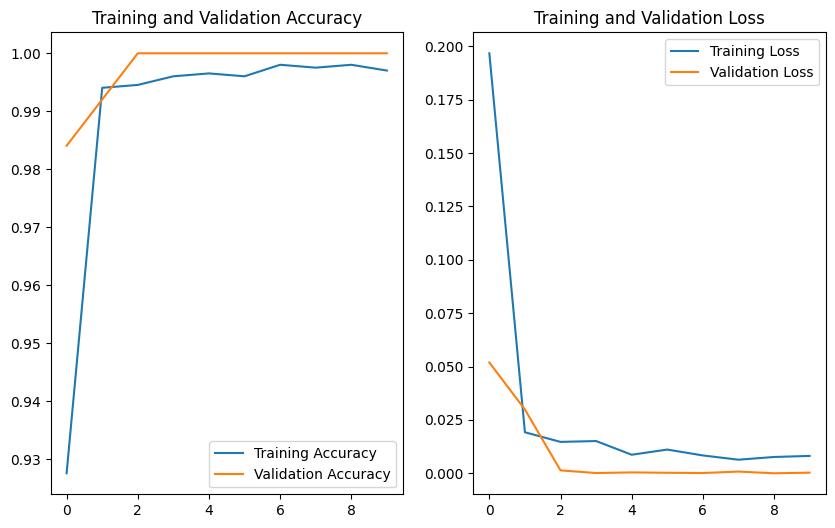

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
prediction = model.predict(X_test)

8/8 [==============================] - 3s 390ms/step


1/1 [==============================] - 0s 163ms/step
Actual label: rock
Predicted label: rock
Confidence: {100.0}


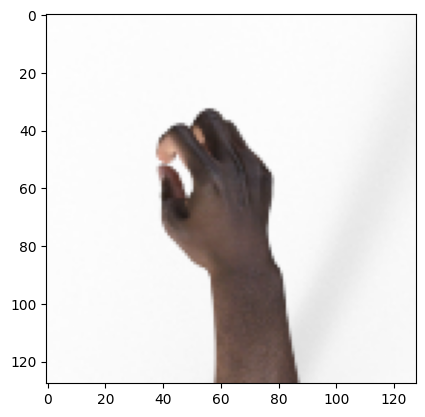

1/1 [==============================] - 0s 82ms/step
Actual label: paper
Predicted label: paper
Confidence: {100.0}


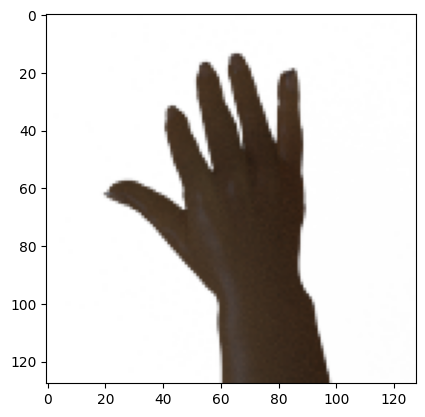

1/1 [==============================] - 0s 82ms/step
Actual label: paper
Predicted label: paper
Confidence: {100.0}


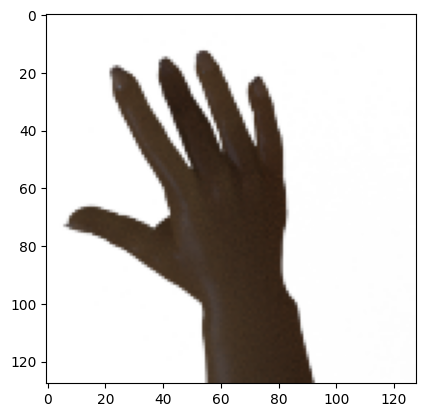

1/1 [==============================] - 0s 75ms/step
Actual label: scissors
Predicted label: scissors
Confidence: {100.0}


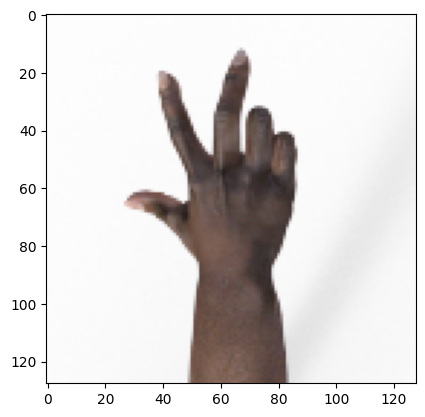

1/1 [==============================] - 0s 71ms/step
Actual label: rock
Predicted label: rock
Confidence: {100.0}


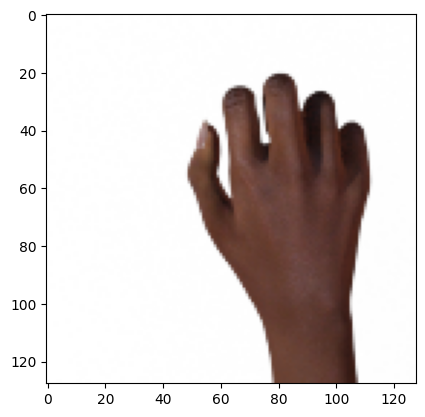

In [18]:
import random

class_names = ['rock', 'paper', 'scissors']

random_indices = np.random.choice(len(X_test), 5, replace=False)

for i in random_indices:
    image = X_test[i].astype('uint8')
    predictions = model.predict(np.expand_dims(X_test[i], axis=0))
    predicted_label = class_names[np.argmax(predictions)]
    actual_label = class_names[np.argmax(y_test[i])]
    confidence = round( (np.max(predictions[0])), 2)
    
    plt.imshow(image)
    print("Actual label:", actual_label)
    print("Predicted label:", predicted_label)
    print("Confidence:", {confidence *100})
    plt.show()

In [19]:
model.save('mod5.h5')

c:\Users\MATRIX COMPUTER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
